# COMP3419 Assignment 2 Option1
## Preprocessing code file
### SID: 470319066

#### Preprocess the Marionette video using openCV

In [1]:
import sys
import os
import cv2
import math
import numpy as np
from imageio import imread, imsave
from IPython.display import clear_output
from matplotlib import pyplot as plt 
%matplotlib inline


## 1. Create folders to store extracted frames and processed images

In [2]:
# Create folders to store frames for processing
if not os.path.isdir(os.path.join(os.getcwd(), 'raw')):
    os.mkdir("raw")
else:
    print('raw folder already exists')

if not os.path.isdir(os.path.join(os.getcwd(), 'binary')):
    os.mkdir("binary")
else:
    print('binary folder already exists')

if not os.path.isdir(os.path.join(os.getcwd(), 'morhp')):
    os.mkdir("morhp")
else:
    print('morhp folder already exists')

if not os.path.isdir(os.path.join(os.getcwd(), 'processed')):
    os.mkdir("processed")
else:
    print('processed folder already exists')

raw folder already exists
binary folder already exists
morhp folder already exists
processed folder already exists


## 2. Extract frames from Marionette video

In [3]:
# Path to the Input video
path_to_video = 'inputVid.mov'

# Capture video and get video/frame details
framenumber = 0
framectr = 0
vid = cv2.VideoCapture(path_to_video)
fy = vid.get(cv2.CAP_PROP_FRAME_HEIGHT)  
fx = vid.get(cv2.CAP_PROP_FRAME_WIDTH)


# Extract the frames from  video
while(1):
    ret, frame = vid.read()
    if not ret:
        break
    print('Extracting: %d' % framenumber)
    clear_output(wait=True)
    cv2.imwrite('raw/%d.tif' % framenumber, frame)
    framenumber += 1
vid.release()

Extracting: 952


## 3. Erosion, Dilation, Padding functions

In [4]:
# erosion, dilation, padding functions

# padding on binary matrix
def add_padding(binary_matrix, se_size):
    pad_size = int(se_size / 2)
    # specify the pading for three dimensions
    # ((1,1), (1,1), (0,0)) => 1 padding for left and right, 
    #                          1 padding for top and bottom, 
    #                          no padding for color channels
    padding_2_dims = ((pad_size, pad_size), (pad_size, pad_size))
    matrix_padded = np.pad(binary_matrix, padding_2_dims, 'constant', constant_values=0)
    return matrix_padded



# dilation
def dilation(binary_matrix, SE): # SE: Structuring element
    if np.max(binary_matrix) == 255:
        binary_matrix = binary_matrix / 255

    dilated_matrix = np.zeros(binary_matrix.shape)
    
    SE_size = SE.shape[0]
    radius = int(SE_size / 2)

    height_max, width_max  = binary_matrix.shape
    
    # pad img
    binary_matrix_padded = add_padding(binary_matrix, SE_size)
    
    for row_idx in range(height_max):
        for col_idx in range(width_max):
            if np.sum(SE*binary_matrix_padded[row_idx : row_idx + SE_size, col_idx : col_idx + SE_size]) > 0:
                dilated_matrix[row_idx, col_idx] = 1


    dilated_matrix *= 255
    return np.array(dilated_matrix)



# erosion
def erosion(binary_matrix, SE):
    if np.max(binary_matrix) == 255:
        binary_matrix = binary_matrix / 255
        
    eroded_matrix = np.zeros(binary_matrix.shape)

    SE_size = SE.shape[0]
    radius = int(SE_size / 2)
    
    height_max, width_max  = binary_matrix.shape

    # pad img
    binary_matrix_padded = add_padding(binary_matrix, SE_size)

    for row_idx in range (radius, height_max-1):
        for col_idx in range (radius, width_max-1):
            if binary_matrix[row_idx, col_idx] == 1 and np.sum(SE*binary_matrix_padded[row_idx : row_idx + SE_size, col_idx : col_idx + SE_size]) == np.sum(SE):
                eroded_matrix[row_idx, col_idx] = 1

    return np.array(eroded_matrix)

## 4. Function to turn eroded/dilated shape into Square
#### (For visualisation purpose)

In [5]:
# turn into square
def toRect(binary_matrix, radius, percent):
    if np.max(binary_matrix) == 255:
        binary_matrix = binary_matrix / 255

    rect_matrix = np.zeros(binary_matrix.shape)

    height_max, width_max  = binary_matrix.shape

    binary_matrix_padded = add_padding(binary_matrix, radius*2)
    padded_hmax, padded_wmax = binary_matrix_padded.shape

    d = 2*radius

    for row_idx in range(height_max):
        for col_idx in range(width_max):
            if np.sum(binary_matrix_padded[row_idx-radius : row_idx+radius, col_idx-radius : col_idx+radius]) > d*d*percent: # more than 25% occuppied
                rect_matrix[row_idx, col_idx] = 1
                rl = max(0, col_idx-radius) 
                rr = min(width_max-1, col_idx+radius)
                rt = max(0, row_idx-radius) 
                rb = min(height_max-1, row_idx+radius)

                bl = max(0, col_idx-2*radius) 
                br = min(padded_wmax-1, col_idx+2*radius)
                bt = max(0, row_idx-2*radius) 
                bb = min(padded_hmax-1, row_idx+2*radius)
                rect_matrix[rt : rb, rl] = 1
                rect_matrix[rt : rb, rr] = 1
                rect_matrix[rt, rl : rr] = 1
                rect_matrix[rb, rl : rr] = 1
                binary_matrix_padded[bt : bb, bl : br] *= 0

    return rect_matrix


## 5. Function to turn eroded/dilated shape into a Single point

In [6]:
# turn into points  
def toPoint(binary_matrix, radius, percent):
    if np.max(binary_matrix) == 255:
        binary_matrix = binary_matrix / 255

    height_max, width_max  = binary_matrix.shape

    binary_matrix_padded = add_padding(binary_matrix, radius*2)
    padded_hmax, padded_wmax = binary_matrix_padded.shape

    d = 2*radius

    points = []
    for row_idx in range(height_max):
        for col_idx in range(width_max):
            # if more than some % of defined area are occuppied
            if np.sum(binary_matrix_padded[row_idx-radius : row_idx+radius, col_idx-radius : col_idx+radius]) > d*d*percent: 
                points.append([row_idx, col_idx]) 

                bl = max(0, col_idx-2*radius) 
                br = min(padded_wmax-1, col_idx+2*radius)
                bt = max(0, row_idx-2*radius) 
                bb = min(padded_hmax-1, row_idx+2*radius)
                binary_matrix_padded[bt : bb, bl : br] *= 0

    return points

## 6. Sample frame testing/visualisation
#### (Jump to Section 7 for Processing of all frames)

### 6.1 Get a sample raw frame and turn into Binary image base on some threshold

C:\Users\wenji\AppData\Local\Temp\ipykernel_12532\4278775756.py:4: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  rgb_img = imread('raw/%d.tif' % process_frame)


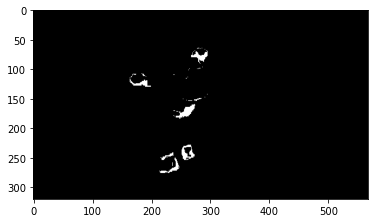

In [7]:
# Sample frame
process_frame = 0

rgb_img = imread('raw/%d.tif' % process_frame)

R = rgb_img[:,:,0]
G = rgb_img[:,:,1]
B = rgb_img[:,:,2]

# turn binary by some threshold
r_thre = (R > 150)
g_thre = (G < 110)
b_thre = (B < 130)
binary_matrix = r_thre * g_thre * b_thre # 2d array 320h * 568w
binary_img = binary_matrix * 255 
plt.imshow(binary_img, cmap='gray')


### 6.2 Apply Erosion to remove nosie

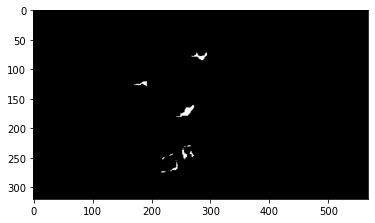

In [8]:
# structuring element
SEe = np.ones((3,3))

# erode img
eroded_img = erosion(binary_img, SEe)
plt.imshow(eroded_img, cmap='gray')

### 6.3 Apply Dilation to connect area of same body part

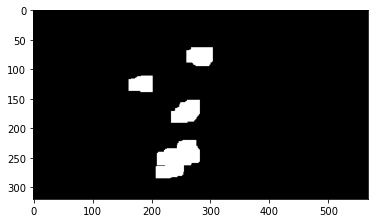

In [9]:
# structuring element
SEd = np.ones((20,20))

# dilate img
dilated_img = dilation(eroded_img, SEd)
plt.imshow(dilated_img, cmap='gray')

### 6.4 Turn into square and get centriod coordinate

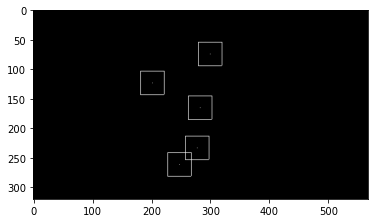

In [10]:
rect_img = toRect(dilated_img, 20, 0.25)
plt.imshow(rect_img, cmap='gray')

In [11]:
points = toPoint(dilated_img, 20, 0.25)
print(points)

[[74, 300], [123, 202], [165, 283], [233, 278], [261, 248]]


## 7. Process the raw frames
#### 1. Turn into binary image base on some rgb threshold 
#### 2. erode to remove noise
#### 3. dilate to connect disjointed area of same body part
#### 4. turn into square base on % of area occupied and get centriod coordinate
#### 5. keep a 2D Python list that stores all points (num_of_frames * points_in_frame)

In [12]:
# process frame, counter variables
framectr = framenumber - 1
process_frame = 0

# structuring element
SEe = np.ones((3,3))
SEd = np.ones((20,20))

# stores the coordinates for each frame
points_allframe = []

# process each frame
while process_frame < framectr:
    rgb_img = imread('raw/%d.tif' % process_frame)

    R = rgb_img[:,:,0]
    G = rgb_img[:,:,1]
    B = rgb_img[:,:,2]

    # turn binary by some threshold
    r_thre = (R > 150)
    g_thre = (G < 110)
    b_thre = (B < 130)
    binary_matrix = r_thre * g_thre * b_thre

    # process binary image (erode + dilate)
    binary_matrix = erosion(binary_matrix, SEe)
    binary_matrix = dilation(binary_matrix, SEd)

    # get result points
    points_currframe = toPoint(binary_matrix, 20, 0.25)
    points_allframe.append(points_currframe)

    print(process_frame, points_currframe)
    clear_output(wait=True)

    # for visualisation purpose, COMMENT THE 3 LINES BELOW TO INCREASE THE PROCESSING SPEED
    rect_matrix = toRect(binary_matrix, 20, 0.25)
    rect_matrix = rect_matrix * 255
    cv2.imwrite('morhpNew/%d.tif' % process_frame, rect_matrix)

    #process next frame
    process_frame+=1

2 [[78, 308], [147, 204], [166, 284], [223, 272], [254, 254]]


In [13]:
# make a copy instead make direct modifcation to extracted point
# so don't need to re-run is error made
all_points = points_allframe.copy()

In [14]:
# keep a saved csv 
with open("points.csv",'w') as f:
    for ls in all_points:
        str_ls = ''
        for coords in ls:
            str_ls += ','.join(str(item) for item in coords)
            str_ls += ','
        str_ls = str_ls[:-1]
        str_ls += '\n'
        f.write(str_ls)

In [15]:
# read a saved csv 
points_csv = []
with open("points.csv",'r') as f:
    for line in f:
        points = []
        line = line.strip('\n').split(',')
        for i in range(int(len(line)/2)):
            y = int(line[2*i])
            x = int(line[2*i+1])
            p = [y, x]
            #print(y, x)
            points.append(p)
        points_csv.append(points)


## 8. Further Processing to  Assign each point to a body part (Keep 5 points per frame)

### 8.1 Function to get boundaries from the set of coordinate
gets the left, right, top, bottom bound of the monkey(extracted coordinates) in a frame

In [16]:
def getBound(coords):
    boundL = fx
    boundR = 0 
    boundT = fy
    boundB = 0

    # get bound of points# [y, x]
    for coor in coords:  
        y = coor[0]
        x = coor[1]
        if y < boundT:
            boundT = y
        if y > boundB:
            boundB = y
        if x < boundL:
            boundL = x
        if x > boundR:
            boundR = x
    
    return [boundL, boundR, boundT, boundB]

### 8.2 Function to assign Point to body part base on distance to the boundaries
#### (Method 1) - used for first frame and when there is more than 5 points in the frame

In [17]:
# assign coord to body part base on bound
# top-left = left arm
# top-right = right arm
# centre = body
# bot-left = left leg
# bot-right = right leg
def assign_on_bound(boundL, boundR, boundT, boundB, coords):
    max_dist = math.dist([boundL, boundT], [boundR, boundB])
    left_arm = right_arm = body = left_leg = right_leg = [-1, -1]
    lt = lb = rt = rb = ct = max_dist
    for coor in coords:
        y = coor[0]
        x = coor[1]
        # lt
        if math.dist([boundL, boundT], [x, y]) <= lt:
            lt = math.dist([boundL, boundT], [x, y]) 
            left_arm = tuple([y, x])
        if math.dist([boundR, boundT], [x, y]) <= rt:
            rt = math.dist([boundR, boundT], [x, y]) 
            right_arm = tuple([y, x])
        if math.dist([boundL, boundB], [x, y]) <= lb:
            lb = math.dist([boundL, boundB], [x, y]) 
            left_leg = tuple([y, x])
        if math.dist([boundR, boundB], [x, y]) <= rb:
            rb = math.dist([boundR, boundB], [x, y]) 
            right_leg = tuple([y, x])
        if math.dist([(boundL+boundR)/2, (boundT+boundB)/2], [x, y]) <= ct:
            ct = math.dist([(boundL+boundR)/2, (boundT+boundB)/2], [x, y]) 
            body = tuple([y, x])
        
    return [body, left_arm, right_arm, left_leg, right_leg ]


# get displacement between centriod of rect bound
def get_bound_dist(b1, b2):
    b1c = [(b1[0]+b1[1])/2, (b1[2]+b1[3])/2]
    b2c = [(b2[0]+b2[1])/2, (b2[2]+b2[3])/2]

    return math.dist(b1c, b2c)



### 8.3 Function to assign Point to body part base on distance between previously assign points
#### (Method 2) - used when less or equal to 5 points in a frame

In [18]:
def assign_parts(prev_bounds, curr_bounds, curr_points, prev_points):
    # print(curr_points)
    # print(prev_points)
    boundL = curr_bounds[0]
    boundR = curr_bounds[1]
    boundT = curr_bounds[2]
    boundB = curr_bounds[3]
    centx = (boundR + boundL)/2
    centy = (boundB + boundT)/2

    

    # for points in current frame
    # look for closets parts in previous frame
    closests = []
    for p in curr_points:
        min_dist = float('inf')
        closest = None
        for prev in prev_points:
            if math.dist(p, prev) < min_dist:
                min_dist = math.dist(p, prev)
                closest = prev
        #print(closest)
        closests.append(closest)

    curr_parts = prev_points.copy()
    for i in range(0, len(curr_parts)):
        for j in range(0, len(closests)):
            if curr_parts[i] == closests[j]:
                curr_parts[i] = curr_points[j]

    # check
    left_arm = curr_parts[1]
    body = curr_parts[0]
    if body[1] < left_arm[1]:
        curr_parts[0] = left_arm
        curr_parts[1] = body

    return curr_parts


### 8.5 Process all points

In [19]:
# for following frames consider the closets to prev point
# look for closets point within some radius
all_parts = []
z = 0
dup = 0 
dup1 = 0
for f in all_points:
    candidates = []
    prev_parts = []
    z +=1
    # for first frame, define by considering the distance to bounds
    if len(f) > 5 or f==all_points[0]:
        prev_parts = f.copy()
        boundL, boundR, boundT, boundB = getBound(f)
        candidates = assign_on_bound(boundL, boundR, boundT, boundB, f)
        all_parts.append(candidates)
    else:
        prev_parts = all_parts[-1].copy()
        candidates = prev_parts.copy()
        curr_to_prev = [ [] for i in range(5) ]
        for coor in f:
            min_dist = float('inf')
            part_i = -1
            for i in range(0, len(prev_parts)):
                if math.dist(prev_parts[i], coor) < min_dist:
                    min_dist = math.dist(prev_parts[i], coor)
                    part_i = i
            curr_to_prev[part_i].append(tuple(coor))
        
        for i in range(len(curr_to_prev)):
            if(len(curr_to_prev[i])) == 1:
                candidates[i] = tuple(curr_to_prev[i][0])
            elif(len(curr_to_prev[i])) >= 1:
                # get ave of all points
                y = 0
                x = 0
                for j in range(len(curr_to_prev[i])):
                    y += curr_to_prev[i][j][0]
                    x += curr_to_prev[i][j][1]
                y = y/len(curr_to_prev[i])
                x = x/len(curr_to_prev[i])
                candidates[i] = tuple([int(y), int(x)])

        all_parts.append(candidates)
    # if two parts used same point
    if len(set(candidates)) < len(candidates):
        for i in range(0, len(candidates)-1):
            solved = False
            for j in range(i+1, len(candidates)):
                if candidates[i] == candidates[j]:
                    #candidates[i] = tuple(prev_parts[i])
                    candidates[j] = tuple(prev_parts[j])
                    solved = True 
                    break 
            if solved:
                break



### 8.4 Draw square with different colour base on assigned part
#### (For visualisation purpose)

In [20]:
def processed_rect(processed_img, parts, radius):
    processed_img = np.zeros(rgb_img.shape)
    height_max, width_max, channels  = processed_img.shape

    colours = [[255,0,0],[0,255,0],[0,0,255],[255,255,0],[255,0,255]]

    for i in range(0,len(parts)):
        r0,c0 = parts[i]

        l = max(0, c0-radius) 
        r = min(width_max-1, c0+radius)
        t = max(0, r0-radius) 
        b = min(height_max-1, r0+radius)
        
        processed_img[t:b, l:r] = colours[i]

    return processed_img

In [21]:
process_frame = 0

for i in range(0, len(all_parts)):
    p = all_parts[i]

    # # for visualisation purpose
    processed_img = processed_rect(rgb_img, p, 20)
    #plt.imshow(processed_img)
    cv2.imwrite('processed/%d.tif' % i, processed_img)


## 9. Save the processed points into a CSV file
5 points per line/frame as : 
body, left_arm, right_arm, left_leg, right_leg

In [22]:
# keep a saved csv 
with open("coords.csv",'w') as f:
    for ls in all_parts:
        str_ls = ''
        for coords in ls:
            str_ls += ','.join(str(item) for item in coords)
            str_ls += ','
        str_ls = str_ls[:-1]
        str_ls += '\n'
        f.write(str_ls)